In [ ]:
#GENERAL
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

#PATH PROCESS
import os
from pathlib import Path
import glob
from scipy.io import loadmat

# image processing
import cv2
from scipy.ndimage import gaussian_filter

# Neural Network
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision

**Exploring Dataset**

In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/archive.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

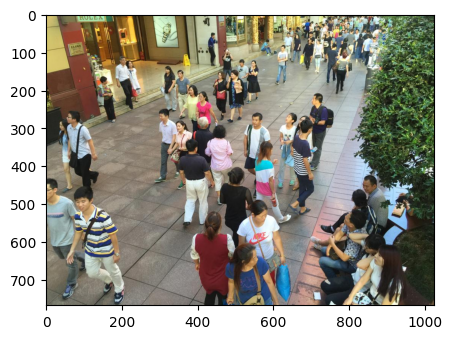

In [ ]:
path_img_ex = '/content/ShanghaiTech/part_B/train_data/images/IMG_7.jpg'
image_ex = cv2.cvtColor(cv2.imread(path_img_ex),cv2.COLOR_BGR2RGB)
figure = plt.figure(figsize=(5,5))
plt.imshow(image_ex)
plt.show()

type:  <class 'dict'>


Text(0.5, 1.0, 'Image and Coordinate')

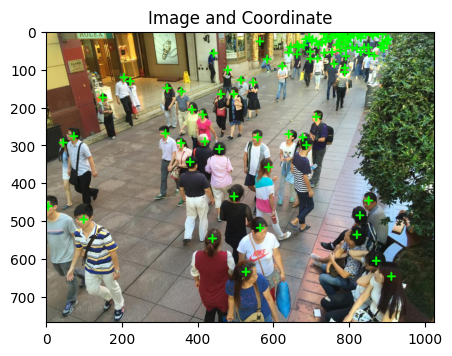

In [ ]:
path_gt_ex = "/content/ShanghaiTech/part_B/train_data/ground-truth/GT_IMG_7.mat"
gt_ex = loadmat(path_gt_ex)
print('type: ', type(gt_ex))
gt_coor_ex = gt_ex.get('image_info')[0][0][0][0][0]
figure = plt.figure(figsize=(5,5))

for x_cor, y_cor in gt_coor_ex:
    cv2.drawMarker(image_ex, (int(x_cor), int(y_cor)),(0, 255, 0),thickness=3)

plt.imshow(image_ex)
plt.title("Image and Coordinate")


Now next step is :

Extract the coordinate as density map. With the function create_density_map, the coordinate of people can be visulized, the sum of the density map is the amount of people in the image, the size of the density map is the same as the image.

The density map will be used as 'label' for neural network.


DM:  Expected crowd density

GT: Ground Truth of the picture


In [ ]:
def gen_density_map_gaussian(image, coords, sigma=5):
    img_zeros = np.zeros((image.shape[:2]), dtype=np.float32)
    for x_cor, y_cor in coords:
        img_zeros[int(y_cor), int(x_cor)] = 1

    density_map = gaussian_filter(img_zeros,sigma=sigma,truncate=5*5)

    return density_map

max1 :  tensor(1.)
max2 :  0.029189795
min1 :  tensor(0.)
min2 :  0.0


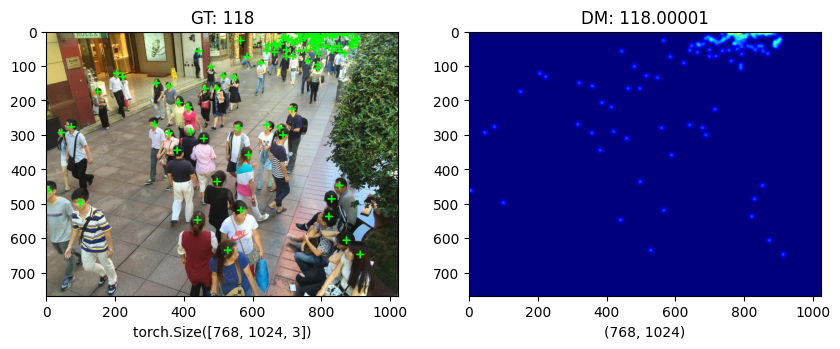

In [ ]:
density_map_ex = gen_density_map_gaussian(image_ex, gt_coor_ex, 5)

figure = plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
image_ex = torch.tensor(image_ex/255, dtype=torch.float)
plt.xlabel(image_ex.shape)
plt.title('GT: '+str(gt_coor_ex.shape[0]))
plt.imshow(image_ex)

plt.subplot(1,2,2)
plt.xlabel(density_map_ex.shape)
plt.title('DM: '+str(np.sum(density_map_ex)))
plt.imshow(density_map_ex, cmap="jet")

print('max1 : ', image_ex.max())
print('max2 : ', density_map_ex.max())
print('min1 : ', image_ex.min())
print('min2 : ', density_map_ex.min())

**Data Loader**

Create a data loader extract the key 'image_info' in MAT to obtain the coordinates of people location. Then use the gen_density_map_gaussian to create the density map of each image. In addition, take the dimension of the coordinate matrix as number of people, which can be used for model loss function. Downsample is applied in order to fit the shape of density map at output of training model.

In [ ]:
class DataLoader(Dataset):
    def __init__(self, root_dir, gt_downsample=4, shuffle=False):
        self.root_dir = root_dir
        self.gt_downsample = gt_downsample
        self.shuffle = shuffle


        self.img_names = [filename for filename in os.listdir(os.path.join(root_dir, 'images')) if filename.endswith('.jpg')]

        if self.shuffle:
            random.shuffle(self.img_names)

        self.n_people = {}
        self.DMs = {}
        for image_filename in self.img_names:
            img_path = os.path.join(root_dir, 'images', image_filename)
            GT_filename = 'GT_' + image_filename.split('.')[0] + '.mat'
            path_GT = os.path.join(root_dir, 'ground-truth', GT_filename)
            GT = loadmat(path_GT).get('image_info')[0][0][0][0][0]
            img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
            self.DMs[img_path] = gen_density_map_gaussian(img, GT, 5)
            self.n_people[img_path] = GT.shape[0]


    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, 'images', self.img_names[index])  # Include the directory path
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        gt_density_map = self.DMs[img_path]
        gt_n_people = self.n_people[img_path]

        if len(img.shape) == 2: # expand grayscale image to three channel.
            img = img[:, :, np.newaxis]
            img = np.concatenate((img, img, img), 2)

        # downsample = is applied in order to fit the shape of density map at output of training model.
        ds_rows = int(img.shape[0] // self.gt_downsample)
        ds_cols = int(img.shape[1] // self.gt_downsample)
        img = cv2.resize(img, (ds_cols*self.gt_downsample, ds_rows*self.gt_downsample))
        gt_density_map = cv2.resize(gt_density_map, (ds_cols, ds_rows))
        gt_density_map = gt_density_map[np.newaxis, :, :] * self.gt_downsample * self.gt_downsample

        img = img.transpose((2,0,1)) # convert to order (channel, rows, cols)
        img_tensor = torch.tensor(img/255, dtype=torch.float)
        dm_tensor = torch.tensor(gt_density_map, dtype=torch.float)

        return img_tensor, dm_tensor, gt_n_people


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
root_dir = "/content/ShanghaiTech/part_B/test_data"
dataset = DataLoader(root_dir, gt_downsample=4, shuffle=True)

**Now lets do some sanity check**

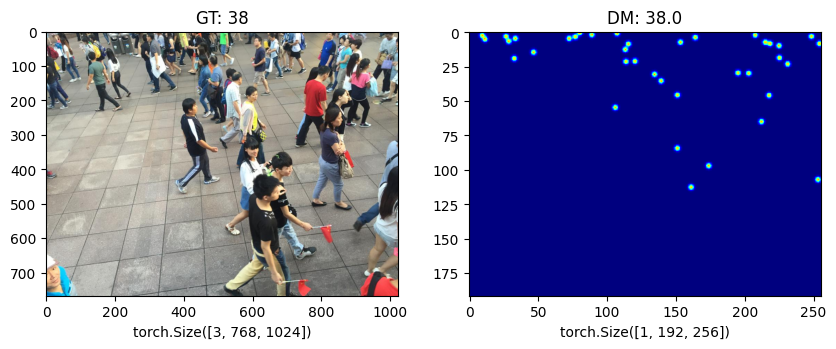

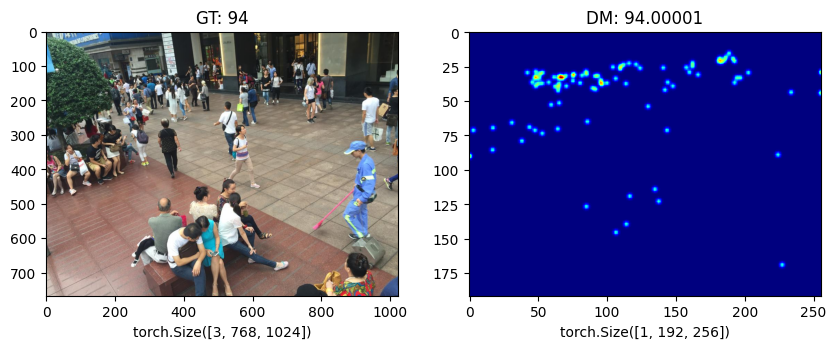

type of img:  <class 'torch.Tensor'>
type of dmap:  <class 'torch.Tensor'>
shape of img:  torch.Size([3, 768, 1024])


In [ ]:
for i, (img, gt_dmap, n_people) in enumerate(dataset):
  plt.figure(figsize=(10, 5))
  plt.subplot(1,2,1)
  plt.xlabel(img.shape)
  plt.title('GT: ' + str(n_people))
  plt.imshow(img.permute(1, 2, 0))

  plt.subplot(1,2,2)
  plt.xlabel(gt_dmap.shape)
  plt.title('DM: ' + str(np.sum(gt_dmap.numpy())))
  plt.imshow(gt_dmap.permute(1, 2, 0), cmap="jet")
  plt.show()

  if i > 0:
    print('type of img: ', type(img))
    print('type of dmap: ', type(gt_dmap))
    print('shape of img: ', img.shape)
    break

**Create Model for Neural Network**


Build a multi-column convolutional neural network for density map prediction.

The multi-column CNN consists of multiple parallel CNN columns, each processing the input data independently and at different resolutions. In the proposed architecture, the 1st column is with lowest resolution (with largest kernel size), and lowest depth; 2nd column has incresing resolution (smaller kernel size), and larger depth, and so on.

Each CNN column learns to extract features that contains different aspects from the input data. After feature extraction, the outputs from the all CNN columns are combined by concatenation. The combined features are passed through a single convolutional layer to generate the final output.

In [ ]:
class MC_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.column1 = nn.Sequential(
            nn.Conv2d(3, 8, 9, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(8, 16, 7, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 7, padding='same'),
            nn.ReLU(),
            nn.Conv2d(32, 16, 7, padding='same'),
            nn.ReLU(),
            nn.Conv2d(16, 8, 7, padding='same'),
            nn.ReLU(),
        )

        self.column2 = nn.Sequential(
            nn.Conv2d(3, 10, 7,padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(10, 20, 5,padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(20, 40, 5,padding='same'),
            nn.ReLU(),
            nn.Conv2d(40, 20, 5,padding='same'),
            nn.ReLU(),
            nn.Conv2d(20, 10, 5,padding='same'),
            nn.ReLU(),
        )

        self.column3 = nn.Sequential(
            nn.Conv2d(3, 12, 5, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(12, 24, 3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(24, 48, 3, padding='same'),
            nn.ReLU(),
            nn.Conv2d(48, 24, 3, padding='same'),
            nn.ReLU(),
            nn.Conv2d(24, 12, 3, padding='same'),
            nn.ReLU(),
        )


        self.fusion_layer = nn.Sequential(
            nn.Conv2d(30, 1, 1, padding=0),
            #nn.ReLU()
        )


    def forward(self,img_tensor):
        x1 = self.column1(img_tensor)
        x2 = self.column2(img_tensor)
        x3 = self.column3(img_tensor)
        x = torch.cat((x1, x2, x3),1)
        x = self.fusion_layer(x)
        return x


In [ ]:
img=torch.rand((1,3,768,1024),dtype=torch.float)
mcnn=MC_CNN()
out_dmap=mcnn(img)
print(out_dmap.shape)

torch.Size([1, 1, 192, 256])


**Getting data ready for traning, validation, and testing**

In [ ]:
batch_size = 8
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

train_root_dir = "/content/ShanghaiTech/part_B/train_data"
init_training_set = DataLoader(train_root_dir, gt_downsample=4, shuffle=True)

# split part of the training set as validation set
train_size = int(0.9 * len(init_training_set))
val_size = len(init_training_set) - train_size

train_indices = list(range(train_size))
val_indices = list(range(train_size, len(init_training_set)))
train_dataset = torch.utils.data.dataset.Subset(init_training_set, train_indices)
val_dataset = torch.utils.data.dataset.Subset(init_training_set, val_indices)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_root_dir = "/content/ShanghaiTech/part_B/train_data"
test_set = DataLoader(test_root_dir, gt_downsample=4, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

print("Number of batches in train_loader:", len(train_loader))
print("Number of batches in val_loader:", len(val_loader))
print("Number of batches in test_loader:", len(test_loader))

Number of batches in train_loader: 45
Number of batches in val_loader: 5
Number of batches in test_loader: 50


In [ ]:
def plot_corresponding_pairs(batch1, batch2, plot_map='jet'):
    num_images = batch1.shape[0] # can change to 4 if for entire data set

    fig, axes = plt.subplots(int(np.ceil(num_images/2)), 4)

    for i in range(num_images):
        axes[int(i/4)*2, i%4].imshow(batch1[i].permute(1, 2, 0))
        axes[int(i/4)*2, i%4].axis('off')

        axes[int(i/4)*2+1, i%4].imshow(batch2[i].squeeze().detach().numpy(), cmap=plot_map)
        axes[int(i/4)*2+1, i%4].axis('off')
        axes[int(i/4)*2+1, i%4].set_title('DM: ' + str(np.sum(batch2[i].detach().numpy())))

    plt.tight_layout()
    plt.show()

**Printing some samples of dataset as a sanity check**

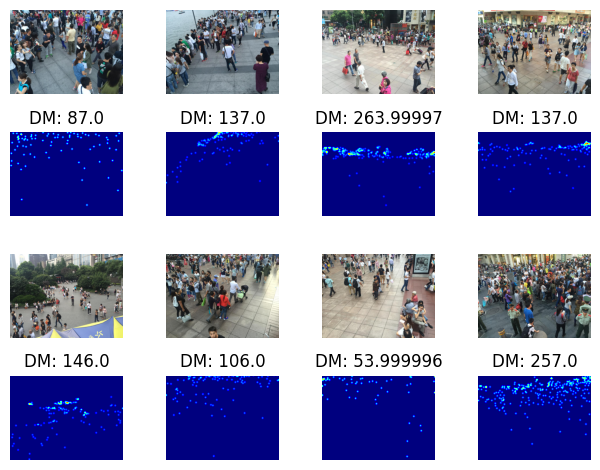

   87   137   264   137   146   106    54   257


In [ ]:
dataiter = iter(train_loader)
ex_images, ex_dmaps, ex_n_people = next(dataiter)


# Show images and density map
plot_corresponding_pairs(ex_images, ex_dmaps)

# Print Ground truth number of people
print(' '.join('%5s' % ex_n_people[j].item() for j in range(batch_size)))

**Training Phase**

Define a cost function that considering:

* Difference between density map and predicted image
* Difference between sum of predicted image (refering number of people) and the ground truth number of people



In [ ]:
class CombinedLoss(nn.Module):
    def __init__(self, weight_dmap=0.8, weight_sum_gt=0.2):
        super().__init__()
        self.weight_dmap = weight_dmap
        self.weight_sum_gt = weight_sum_gt
        self.img_loss = nn.MSELoss()
        self.gt_loss_mse = nn.MSELoss()
        self.gt_loss_mae = nn.L1Loss()

    def forward(self, logits, batch_dmap, batch_gts):
        batch_gts = batch_gts.float()
        img_loss = self.img_loss(logits, batch_dmap)
        gt_loss_mae = self.gt_loss_mae(torch.squeeze(logits.sum(dim=(2,3))), batch_gts)
        gt_loss_mse = self.gt_loss_mse(torch.squeeze(logits.sum(dim=(2,3))), batch_gts)

       # print('logits : ', torch.squeeze(logits.sum(dim=(2,3))))
       #print('gts    : ', batch_gts)
       #print('MAE:  ', gt_loss_mae)

        combined_loss = self.weight_dmap * img_loss + self.weight_sum_gt * gt_loss_mae
        return combined_loss, gt_loss_mae

In [ ]:
num_epochs = 15
#train_losses = np.zeros(num_epochs)
#val_losses = np.zeros(num_epochs)
train_losses = []
val_losses = []
train_mae_losses = []
val_mae_losses = []


model = MC_CNN().to(device)
criterion = CombinedLoss(0.8, 0.2)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
best_val_loss = np.inf
best_nr_epoch = 0

for epoch in range(num_epochs):
    print("Epoch {}:".format(epoch))

    # training phase
    tr_loss_acc = 0.0
    tr_loss_mae_acc = 0.0

    for batch_img, batch_dmap, batch_gts in train_loader:
        # Put data on device
        batch_img, batch_dmap, batch_gts = batch_img.to(device), batch_dmap.to(device), batch_gts.to(device)
        # Predict and get loss
        logits = model(batch_img)
        loss, mae_loss = criterion(logits, batch_dmap, batch_gts)
        # Update model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Keep running statistics
        tr_loss_acc += loss.item()
        tr_loss_mae_acc += mae_loss.item()
        #print('acc mae = ', tr_loss_mae_acc)


    tr_loss = tr_loss_acc / len(train_loader.dataset) # change to this when entire dataset
    tr_mae = tr_loss_mae_acc / len(train_loader.dataset)
    print('>> TRAIN: Epoch {} | tr_loss:  {:.6f}'.format(epoch, tr_loss))
    print('>> TRAIN: Epoch {} | mae:      {:.6f}'.format(epoch, tr_mae))

    # Get validation results
    with torch.inference_mode():
        val_loss_acc = 0.0
        val_loss_mae_acc = 0.0

        for batch_img_val, batch_dmap_val, batch_gts_val in val_loader:
            # Put data on device
            batch_img_val, batch_dmap_val, batch_gts_val = batch_img_val.to(device), batch_dmap_val.to(device), batch_gts_val.to(device)

            # Predict and get loss
            logits = model(batch_img_val)
            loss, mae_loss = criterion(logits, batch_dmap_val, batch_gts_val)

            # Keep running statistics
            val_loss_acc += loss.item()
            val_loss_mae_acc += mae_loss.item()

    val_loss = val_loss_acc / len(val_loader.dataset)
    val_mae = val_loss_mae_acc / len(val_loader.dataset)
    print('>> VAL:   Epoch {} | val_loss: {:.6f}'.format(epoch, val_loss))
    print('>> VAL:   Epoch {} | mae:      {:.6f}'.format(epoch, val_mae))

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_nr_epoch = epoch
        torch.save(model.state_dict(), './crowd_counting.pth')


    train_losses.append(tr_loss)
    train_mae_losses.append(tr_mae)
    val_losses.append(val_loss)
    val_mae_losses.append(val_mae)

print('best training MAE: ', train_mae_losses[best_nr_epoch])
print('best val MAE:      ', val_mae_losses[best_nr_epoch])

Epoch 0:
>> TRAIN: Epoch 0 | tr_loss:  57.281783
>> TRAIN: Epoch 0 | mae:      286.406026
>> VAL:   Epoch 0 | val_loss: 21.933195
>> VAL:   Epoch 0 | mae:      109.665462
Epoch 1:
>> TRAIN: Epoch 1 | tr_loss:  7.893213
>> TRAIN: Epoch 1 | mae:      39.465739
>> VAL:   Epoch 1 | val_loss: 1.947649
>> VAL:   Epoch 1 | mae:      9.738085
Epoch 2:
>> TRAIN: Epoch 2 | tr_loss:  7.330747
>> TRAIN: Epoch 2 | mae:      36.653533
>> VAL:   Epoch 2 | val_loss: 7.704916
>> VAL:   Epoch 2 | mae:      38.524409
Epoch 3:
>> TRAIN: Epoch 3 | tr_loss:  5.771577
>> TRAIN: Epoch 3 | mae:      28.857709
>> VAL:   Epoch 3 | val_loss: 3.299297
>> VAL:   Epoch 3 | mae:      16.496346
Epoch 4:
>> TRAIN: Epoch 4 | tr_loss:  7.095667
>> TRAIN: Epoch 4 | mae:      35.478152
>> VAL:   Epoch 4 | val_loss: 11.250082
>> VAL:   Epoch 4 | mae:      56.250237
Epoch 5:
>> TRAIN: Epoch 5 | tr_loss:  3.627307
>> TRAIN: Epoch 5 | mae:      18.136381
>> VAL:   Epoch 5 | val_loss: 2.068892
>> VAL:   Epoch 5 | mae:      10.3

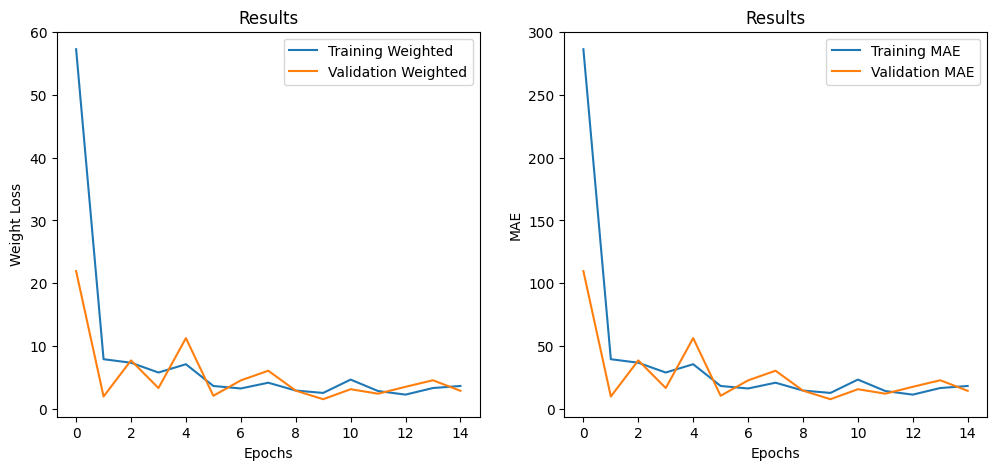

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Weighted')
plt.plot(val_losses, label='Validation Weighted')
plt.title('Results')
plt.ylabel('Weight Loss')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_mae_losses, label='Training MAE')
plt.plot(val_mae_losses, label='Validation MAE')
plt.title('Results')
plt.ylabel('MAE')
plt.xlabel('Epochs')
plt.legend()

plt.show()

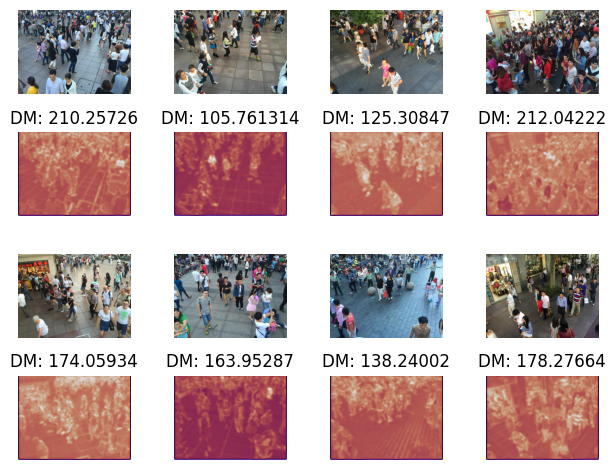

  217    28    46   157   120    99    71    53


In [ ]:
best_model = MC_CNN().to(device)
best_model.load_state_dict(torch.load('./crowd_counting.pth'))
# Get some random validation images
dataiter = iter(val_loader)
ex_images, _, ex_gts  = next(dataiter)


# Show images and density map

pred_dms = best_model(ex_images.to(device))
plot_corresponding_pairs(ex_images.cpu(), pred_dms.cpu(), 'twilight')

# Print labels
print(' '.join('%5s' % ex_gts[j].item() for j in range(batch_size)))

**Test Phase**

In [ ]:
best_model = MC_CNN().to(device)
best_model.load_state_dict(torch.load('./crowd_counting.pth'))
criterion = nn.L1Loss()

test_loss_acc = 0.0
with torch.inference_mode():
    for batch_img, batch_dmap, batch_gts in test_loader:
        batch_img, batch_dmap, batch_gts = batch_img.to(device), batch_dmap.to(device), batch_gts.to(device)

        logits = best_model(batch_img)
        loss = criterion(torch.squeeze(logits.sum(dim=(2,3))), batch_gts)

        # Keep running statistics
        test_loss_acc += loss.item()


# Print results
print('TEST:  test_MAE: {:.3f}'.format(test_loss_acc / len(test_loader.dataset)))


TEST:  test_MAE: 9.847


In [ ]:
best_model = MC_CNN().to(device)
best_model.load_state_dict(torch.load('./crowd_counting.pth'))
criterion_mae = nn.L1Loss()  # Use L1Loss for MAE
criterion_mse = nn.MSELoss()  # Use MSELoss for MSE

test_loss_mae_acc = 0.0
test_loss_mse_acc = 0.0
with torch.no_grad():  # Use no_grad to disable gradient computation
    for batch_img, batch_dmap, batch_gts in test_loader:
        batch_img, batch_dmap, batch_gts = batch_img.to(device), batch_dmap.to(device), batch_gts.to(device)

        logits = best_model(batch_img)
        loss_mae = criterion_mae(torch.squeeze(logits.sum(dim=(2,3))), batch_gts)
        loss_mse = criterion_mse(torch.squeeze(logits.sum(dim=(2,3))), batch_gts)

        # Keep running statistics
        test_loss_mae_acc += loss_mae.item()
        test_loss_mse_acc += loss_mse.item()

# Calculate average losses
test_loss_mae = test_loss_mae_acc / len(test_loader.dataset)
test_loss_mse = test_loss_mse_acc / len(test_loader.dataset)

# Print results
print('TEST:  test_MAE: {:.3f}'.format(test_loss_mae))
print('TEST:  test_MSE: {:.3f}'.format(test_loss_mse))


TEST:  test_MAE: 9.847
TEST:  test_MSE: 1115.069


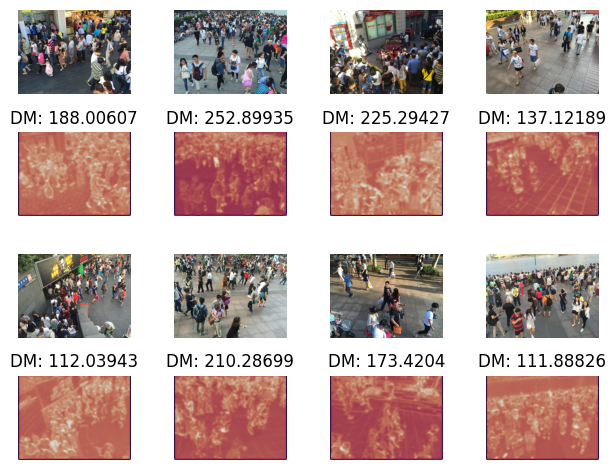

   87   576    54    43   145   175    36   105


In [ ]:
# Get some random validation images
dataiter = iter(test_loader)
ex_images, _, ex_gts  = next(dataiter)


# Show images and density map

pred_dms = best_model(ex_images.to(device))
plot_corresponding_pairs(ex_images.cpu(), pred_dms.cpu(), 'twilight')

# Print labels
print(' '.join('%5s' % ex_gts[j].item() for j in range(batch_size)))